In [1]:
# Imports
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON
import matplotlib.pyplot as plt
from collections import Counter
from dateutil import parser
import isodate
from PIL import Image
import matplotlib.image as mpimg
from wordcloud import WordCloud
from matplotlib.gridspec import GridSpec

In [2]:
# Define API key and initialize YouTube client
api_key = 'xxxxxx'
youtube = build("youtube", "v3", developerKey=api_key)

# Channel IDs
channel_ids = ['UCyd8h6EUXckAJh7xKN1d28g']

# Function to retrieve channel statistics
def get_channel_stats(youtube, channel_ids):
    """
    Fetches statistics for a list of YouTube channels.

    Parameters:
        youtube (Resource): The YouTube API client.
        channel_ids (list): List of channel IDs.

    Returns:
        DataFrame: A DataFrame with channel statistics.
    """
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()
    
    # Parse channel statistics
    all_data = []
    for item in response['items']:
        data = {
            'channelName': item['snippet']['title'],
            'subscribers': item['statistics']['subscriberCount'],
            'views': item['statistics']['viewCount'],
            'totalVideos': item['statistics']['videoCount'],
            'playlistId': item['contentDetails']['relatedPlaylists']['uploads'],
        }
        all_data.append(data)
        
    return pd.DataFrame(all_data)

# Function to retrieve video IDs from a playlist
def get_video_ids(youtube, playlist_id):
    """
    Retrieves all video IDs from a YouTube playlist.

    Parameters:
        youtube (Resource): The YouTube API client.
        playlist_id (str): The playlist ID.

    Returns:
        list: A list of video IDs.
    """
    video_ids = []
    request = youtube.playlistItems().list(
        part="contentDetails",
        playlistId=playlist_id,
        maxResults=50
    )
    response = request.execute()
    
    # Add video IDs from the first page
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
    
    # Loop through pagination
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="contentDetails",
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        )
        response = request.execute()
        
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        
        next_page_token = response.get('nextPageToken')
        
    return video_ids

# Function to retrieve video details
def get_video_details(youtube, video_ids):
    """
    Retrieves details for a list of video IDs.

    Parameters:
        youtube (Resource): The YouTube API client.
        video_ids (list): A list of video IDs.

    Returns:
        DataFrame: A DataFrame with video details.
    """
    all_video_info = []
    for i in range(0, len(video_ids), 50):  # Process in batches of 50
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()
        
        # Parse video details
        for video in response['items']:
            video_info = {
                'video_id': video['id'],
                'title': video['snippet']['title'],
                'description': video['snippet']['description'],
                'publishedAt': video['snippet']['publishedAt'],
                'viewCount': video['statistics'].get('viewCount', 0),
                'likeCount': video['statistics'].get('likeCount', 0),
                'commentCount': video['statistics'].get('commentCount', 0),
                'duration': video['contentDetails']['duration']
            }
            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

In [3]:
# Fetch and preprocess channel and video data
def fetch_and_process_data(youtube, channel_ids):
    """
    Fetches channel and video data, processes it for analysis, and computes summary statistics.

    Parameters:
        youtube (Resource): The YouTube API client.
        channel_ids (list): List of channel IDs.

    Returns:
        tuple: A tuple containing processed data (channel_stats, video_df, summary_statistics).
    """
    # Fetch channel stats and get playlist ID for uploaded videos
    channel_stats = get_channel_stats(youtube, channel_ids)
    playlist_id = channel_stats['playlistId'][0]
    
    # Fetch video details
    video_ids = get_video_ids(youtube, playlist_id)
    video_df = get_video_details(youtube, video_ids)

    # Convert numeric columns to appropriate data types
    numeric_cols_video = ['viewCount', 'likeCount', 'commentCount']
    video_df[numeric_cols_video] = video_df[numeric_cols_video].apply(pd.to_numeric, errors='coerce', axis=1)
    
    # Parse publish date and extract day of the week
    video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
    video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

    # Convert channel stats to numeric
    numeric_cols_channel = ['subscribers', 'views', 'totalVideos']
    channel_stats[numeric_cols_channel] = channel_stats[numeric_cols_channel].apply(pd.to_numeric, errors='coerce', axis=1)
    
    # Prepare summary statistics for dashboard score cards
    summary_statistics = {
        'total_subscribers': channel_stats['subscribers'][0],
        'total_views': channel_stats['views'][0],
        'total_likes': video_df['likeCount'].sum(),
        'total_videos': channel_stats['totalVideos'][0]
    }
    
    # Identify top 10 videos by view count and shorten titles
    top_videos = video_df.nlargest(10, 'viewCount').copy()
    top_videos['short_title'] = top_videos['title'].apply(lambda x: x if len(x) <= 30 else x[:27] + '...')
    
    return channel_stats, video_df, summary_statistics, top_videos

# Fetch and process data
channel_stats, video_df, summary_statistics, top_videos = fetch_and_process_data(youtube, channel_ids)

# Display the first few rows of the processed video data
video_df.head(10)

,video_id,title,description,publishedAt,viewCount,likeCount,commentCount,duration,publishDayName
0,r4RjX8tfu4M,"EMBL´s people: Edith Heard, EMBL Director General","Edith Heard is the Director General of EMBL, t...",2024-10-24 06:00:36+00:00,132,3,0,PT2M56S,Thursday
1,KsQlxTFp-0E,"EMBL´s people: Jan Korbel, Head of Data Scienc...",Jan Korbel is the Head of Data Science and the...,2024-10-17 07:26:14+00:00,210,12,0,PT4M14S,Thursday
2,JebMa72e1Ms,Vitamin B1 transporter enables vitamin B1 to r...,Transport cycle of the human vitamin B1 transp...,2024-10-16 08:23:03+00:00,369,32,1,PT56S,Wednesday
3,wQEN4SmOrgo,EMBL Conference 'Chromatin and epigenetics',Epigenetics refers to heritable changes in gen...,2024-10-14 12:36:26+00:00,252,10,0,PT2M6S,Monday
4,ue1TypC7CYE,"Human nuclear pore complex, a gigantic molecul...",Scientists at EMBL and MPI of Biophysics creat...,2024-10-10 08:26:59+00:00,617,31,1,PT1M,Thursday
5,jnPna_Qf5NE,"EMBL´s people: Melissa Graewert, Beamline scie...",Melissa Graewert is a beamline scientist at E...,2024-10-10 07:33:19+00:00,198,11,0,PT3M42S,Thursday
6,kRJtFYrP-j8,"EMBL´s people: Lorna Richardson, Coordinator f...",Lorna Richardson is a coordinator for the Micr...,2024-10-02 09:04:03+00:00,172,12,0,PT3M42S,Wednesday
7,0q0w0bh7ksc,"EMBL´s people: Emily Savage, Visiting Technica...",Emily Savage is an animal caretaker of the Are...,2024-09-26 07:32:58+00:00,300,8,0,PT3M30S,Thursday
8,mPBEEp2X5JM,"EMBL´s people: Abiram Olivares, PhD student, E...",Abiram Olivares is a first year PhD student at...,2024-09-19 07:54:13+00:00,451,25,1,PT4M10S,Thursday
9,OQu_eMIbFh8,EMBL Course | Genome engineering: CRISPR/Cas i...,This course is providing training in genome ed...,2024-09-16 08:56:16+00:00,347,10,2,PT3M16S,Monday


In [4]:
def plot_best_performing_videos(ax):
    """
    Plots the top 10 best-performing videos by view count.
    Displays the video title on the bar and the view count at the end of the bar.
    """
    bars = ax.barh(top_videos['short_title'][::-1], top_videos['viewCount'][::-1], color='#3B9E62')
    ax.set_xlabel('View Count')
    ax.set_yticks([])
    ax.set_title('Top 10 Best-Performing Videos by View Count', fontsize=16, color=color, fontweight='bold', pad=20, ha='center')

    for bar, title, count in zip(bars, top_videos['short_title'][::-1], top_videos['viewCount'][::-1]):
        # Centered title on the bar
        ax.text(
            bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
            title, ha='center', va='center', color='white', fontsize=8, weight='bold'
        )
        
        # View count at the end of the bar
        ax.text(
            bar.get_width() + 400, bar.get_y() + bar.get_height() / 2,
            f'{count:,}', ha='left', va='center', color='gray', fontsize=9, weight='bold'
        )

def plot_monthly_likes_trend(ax):
    """
    Plots the monthly total likes trend.
    """
    monthly_likes = video_df.groupby(video_df['publishedAt'].dt.to_period('M'))['likeCount'].sum().reset_index()
    monthly_likes['publishedAt'] = monthly_likes['publishedAt'].dt.to_timestamp()
    ax.plot(monthly_likes['publishedAt'], monthly_likes['likeCount'], color='#3B9E62', marker='o')
    ax.set_title('Monthly Total Likes', fontsize=16, color=color, fontweight='bold', pad=20, ha='center')
    # Optional grid and labels
    # ax.set_xlabel('Date')
    # ax.set_ylabel('Total Likes')
    # ax.grid(True, linestyle='--', color='#4C4F56')

def plot_word_cloud(ax):
    """
    Generates and displays a word cloud of the most frequent keywords in video titles and descriptions.
    """
    title_desc_text = " ".join(video_df['title'].fillna('') + " " + video_df['description'].fillna(''))
    basic_stopwords = set([
        'the', 'and', 'for', 'of', 'in', 'to', 'a', 'is', 'with', 'on', 'by', 'an', 'from',
        'at', 'as', 'this', 'that', 'or', 'it', 'be', 'are', 'we', 'you', 'can', 'how', 'what',
        'your', 'has', 'have', 'using', 'more', 'not', 'about', 'which', 'their', 'they', 'these', 
        'will', 'no', 'our', 'was', 'also', 'into', 'who', 'please', 'other', 'but','its','been', 'within', 'video'
    ])
    words = [word.lower() for word in title_desc_text.split() if word.lower() not in basic_stopwords and word.isalpha()]
    word_counts = Counter(words)

    wordcloud = WordCloud(width=1600, height=700, background_color='white', colormap='Greens', max_words=100)
    wordcloud.generate_from_frequencies(word_counts)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title('Top Keywords in Video Titles and Descriptions', fontsize=16, color=color, fontweight='bold', ha='center', pad=20)

def plot_average_views_per_day(ax):
    """
    Plots the average view count per day of the week.
    """
    average_views_per_day = video_df.groupby('publishDayName')['viewCount'].mean().reindex([
        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
    ])
    ax.bar(average_views_per_day.index, average_views_per_day.values, color='#3B9E62')
    ax.set_title('Average View Count per Day of the Week', fontsize=16, color=color, fontweight='bold', pad=20, ha='center')
    # Optional grid and labels
    # ax.set_xlabel('Day of the Week')
    # ax.set_ylabel('Average View Count')
    # ax.grid(axis='y', linestyle='--', color='#4C4F56')

/var/folders/pt/6pkng84j6dd1wfwsdfh2csrw0000gn/T/ipykernel_36633/2363466626.py:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_likes = video_df.groupby(video_df['publishedAt'].dt.to_period('M'))['likeCount'].sum().reset_index()
/var/folders/pt/6pkng84j6dd1wfwsdfh2csrw0000gn/T/ipykernel_36633/1430525915.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


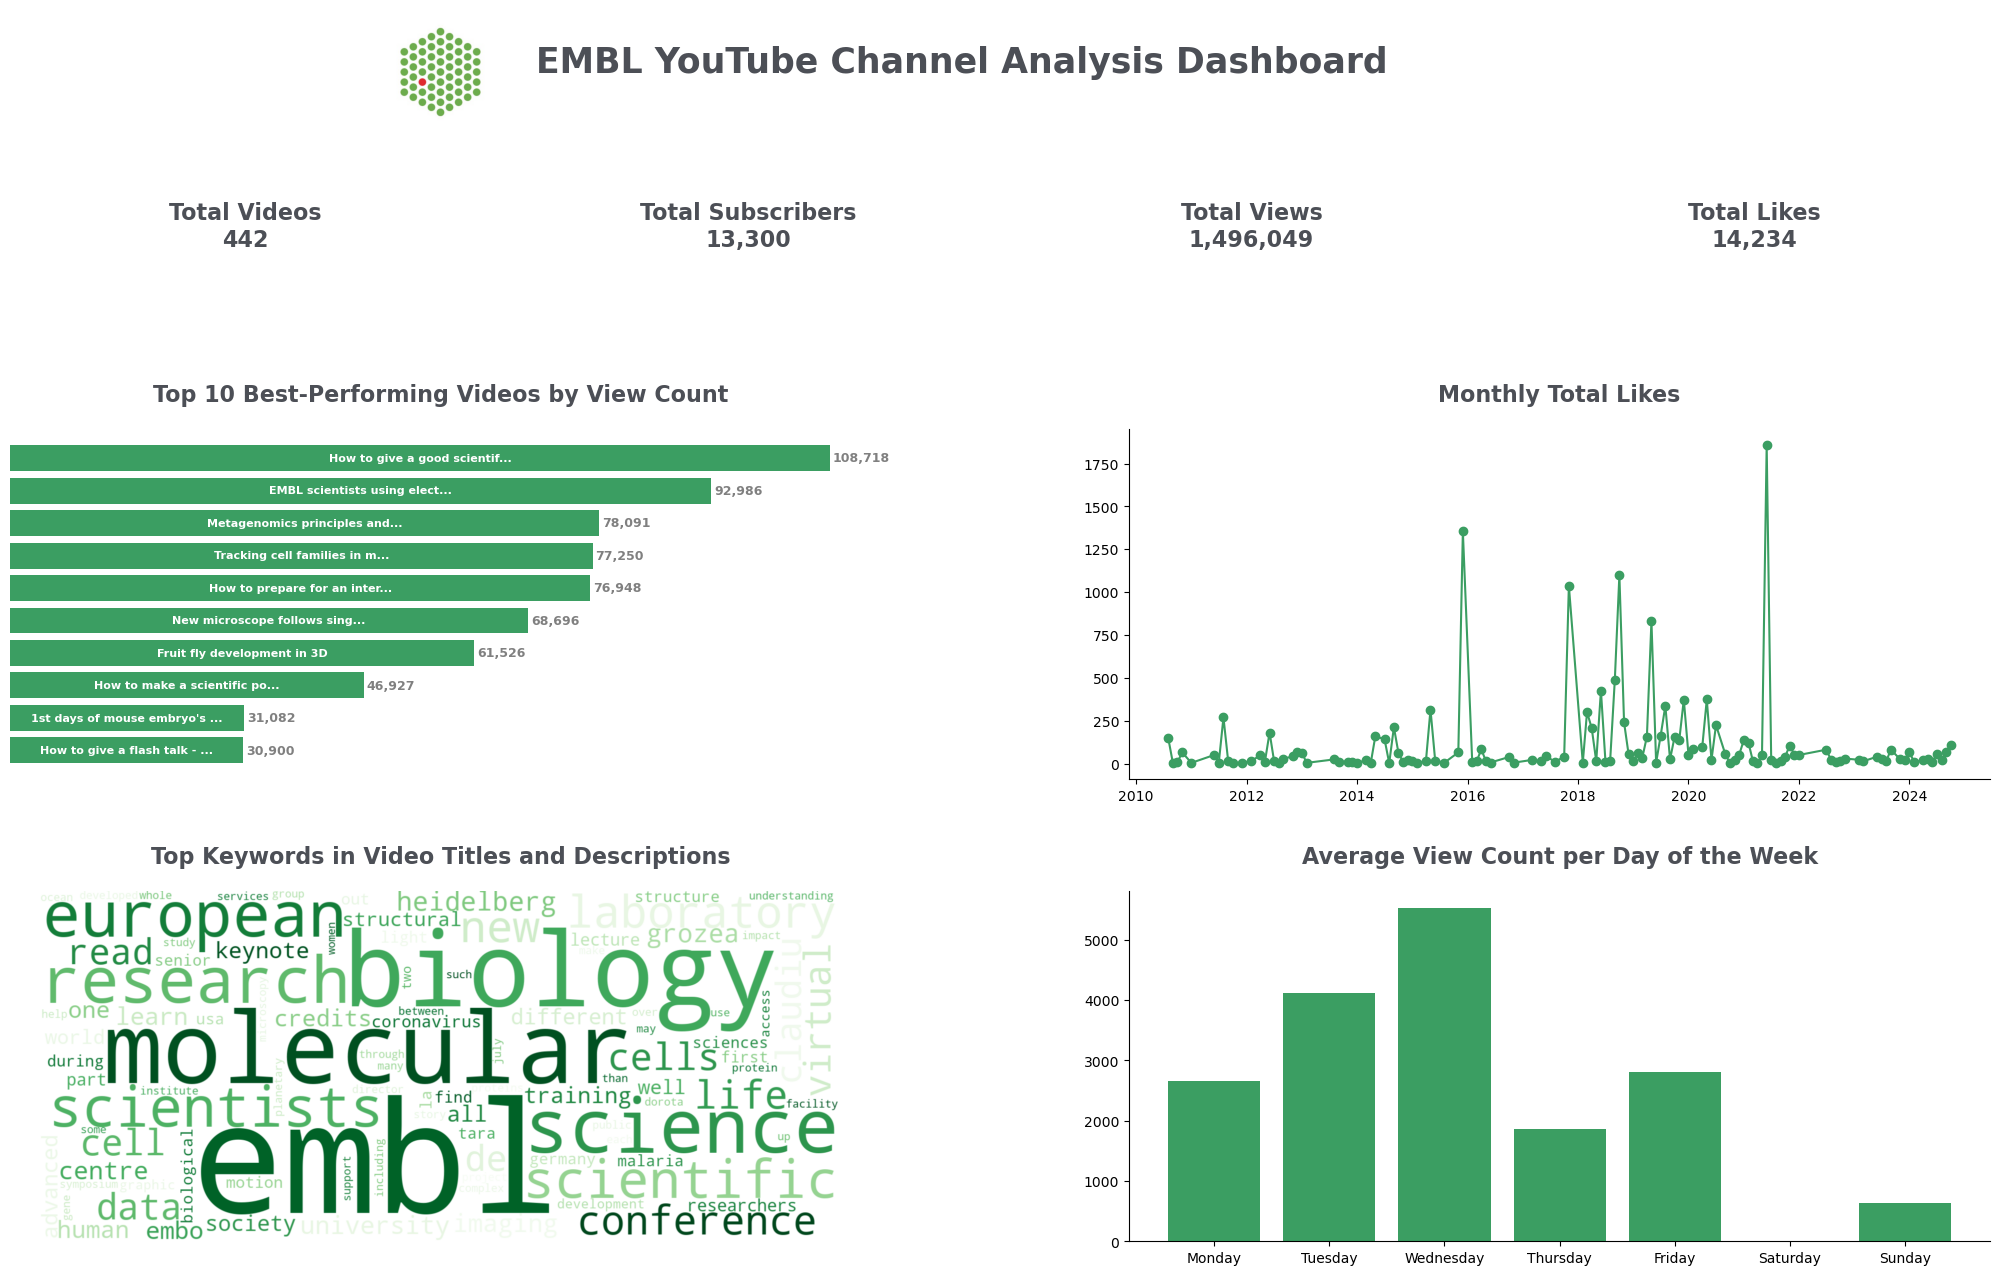

In [5]:
color = '#4C4F56'
# Set up figure with four rows: title/logo, score cards, and two rows for plots
fig = plt.figure(figsize=(22, 16))
gs = GridSpec(4, 2, figure=fig, height_ratios=[0.9, 0.5, 2.5, 2.5], wspace=0.3, hspace=0.5, left=0.05, right=0.95)

# Row 1 - Logo and Title
# Logo in the top left
ax_logo = fig.add_subplot(gs[0, 0])
team1_img = Image.open('/Users/yusuf/Desktop/embl_logo1.jpg')
ax_logo.imshow(team1_img)
ax_logo.axis('off')

# Title in the top right
ax_title = fig.add_subplot(gs[0, 1])
ax_title.text(
    0.3, 0.5, 'EMBL YouTube Channel Analysis Dashboard', 
    fontsize=25, ha='right', fontweight='bold', color=color
)
ax_title.axis('off')

# Row 2 - Score Cards
# Define a new 1x4 GridSpec for the score cards within the second row
score_gs = GridSpec(1, 4, figure=fig, left=0.1, right=0.9, top=0.82, bottom=0.7, wspace=1)
score_titles = ['Total Videos', 'Total Subscribers', 'Total Views', 'Total Likes']
score_values = [
    summary_statistics['total_videos'],
    summary_statistics['total_subscribers'],
    summary_statistics['total_views'],
    summary_statistics['total_likes']
]

# Place each score card in its own column in a single row
for idx, (title, value) in enumerate(zip(score_titles, score_values)):
    ax_score = fig.add_subplot(score_gs[0, idx])
    ax_score.text(
        0.5, 0.5, f"{title}\n{value:,}", 
        ha='center', va='top', fontsize=16, fontweight='bold', color=color
    )
    ax_score.axis('off')

# Row 3 - Main Plots
# Best Performing Videos (third row, left column)
ax1 = fig.add_subplot(gs[2, 0])
plot_best_performing_videos(ax1)
ax1.axis('off')

# Monthly Likes Trend (third row, right column)
ax2 = fig.add_subplot(gs[2, 1])
plot_monthly_likes_trend(ax2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Row 4 - Additional Plots
# Word Cloud (fourth row, left column)
ax3 = fig.add_subplot(gs[3, 0])
plot_word_cloud(ax3)
ax3.axis('off')

# Average Views per Day (fourth row, right column)
ax4 = fig.add_subplot(gs[3, 1])
plot_average_views_per_day(ax4)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# Final adjustments for layout
plt.tight_layout()
plt.show()

In [6]:
fig.savefig('/Users/yusuf/desktop/EMBL-Youtube-Analysis/images/final.png', dpi=300, bbox_inches='tight')